<img src="qiskit-heading.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# *Getting started with Qiskit Chemistry*

Notebook prepared for QuID 2019 school Sep 10th 2019

***
### Contributors
Lukas Moeller<sup>[1]</sup>, Igor Sokolov<sup>[1]</sup>, Pauline Ollitrault<sup>[1]</sup>, Panagiotis Barkoutsos<sup>[1]</sup>, Richard Chen<sup>[2]</sup>, Antonio Mezzacapo<sup>[2]</sup>, Marco Pistoia<sup>[2]</sup>, Stephen Wood<sup>[2]</sup>, Shaohan Hu<sup>[2]</sup>, Peng Liu<sup>[2]</sup>, Jay Gambetta<sup>[2]</sup>
### Affiliation
- <sup>[1]</sup>IBM Research Zuerich
- <sup>[2]</sup>IBMQ

### Installation

You have to have Qiskit installed to run it. See https://qiskit.org/documentation/install.html for installation guidelines.

For a last minite installation (without Anaconda):

- install Python 3.7 by downloading from official website

and then, in the Terminal, write
- pip install qiskit 

this will install qiskit-aqua that contains the chemistry package and all dependencies.

### Introduction
This notebook introduces you to Qiskit Chemistry. It demonstrates the computation of the ground state of molecular Hydrogen using the Variational Quantum Eigensolver (VQE). Different variational forms and qubit 
mappings can be used.

### Variational algorithm for quantum chemistry problems

In order to find the optimal parameters $\boldsymbol\theta^*$ that correspond to the ground state wavefunction, we set up a closed optimization loop between quantum and classical computer, based on some stochastic or gradient-based optimization routine. 

1. Map the fermionic Hamiltonian $H$ to a qubit Hamiltonian $H_P$.
2. Choose the maximum depth and type of the quantum circuit (Variational Form) to efficiently explore the Hilbert space.
3. Choose a set of controls $\boldsymbol\theta$ and make a trial function $|\psi(\boldsymbol\theta)\rangle$. 
4. Evaluate the energy $E(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)~|H_P|~\psi(\boldsymbol\theta)\rangle$ by sampling each Pauli term individually, or sets of Pauli terms (grouped commuting Paulis) that can be measured in the same tensor product basis.
5. Use a classical optimizer (SPSA, L-BFGS-B, COBYLA ...) to choose a new set of controls $\boldsymbol\theta$.
6. Run the classical optimization until the energy has converged, hopefully close to the real solution $\boldsymbol\theta^*$, global minimum, and return the last value of $E(\boldsymbol\theta)$.


References and additional details:

[1] A. Kandala, A. Mezzacapo, K. Temme, M. Takita, M. Brink, J. M. Chow, and J. M. Gambetta, *Hardware-efficient Variational Quantum Eigensolver for Small Molecules and Quantum Magnets*, Nature 549, 242 (2017), and references therein.

[2] Panagiotis Kl. Barkoutsos, Jerome F. Gonthier, Igor Sokolov, Nikolaj Moll, Gian Salis, Andreas Fuhrer, Marc Ganzhorn, Daniel J. Egger, Matthias Troyer, Antonio Mezzacapo, Stefan Filipp, and Ivano Tavernelli *Quantum algorithms for electronic structure calculations: Particle-hole Hamiltonian and optimized wave-function expansions* Phys. Rev. A 98, 022322 – Published 20 August 2018

### Starting with H2

In this notebook, we decompose the computation of the ground state energy of a molecule into 4 steps:
  1. Define a molecule and get integrals `h1, h2` from a computational chemistry driver (PySCF in this case)
  2. Construct a Fermionic Hamiltonian and map it onto a qubit Hamiltonian using a fermion-to-qubit `mapping`.
  3. Instantiate and initialize dynamically-loaded algorithmic components, such as the quantum algorithm `vqe`, the `optimizer` and `variational form` it will use, and the `initial_state` to initialize the variational form.
  4. Run the algorithm on a quantum `backend` and retrieve the results.

First, we have to import the necessary components to run our simulation. We will explain the different components at the point, where they are used.

In [1]:
# import common packages

import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, IBMQ, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import noise

# lib from Qiskit Aqua

from qiskit.aqua import Operator, QuantumInstance
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import COBYLA, SPSA, L_BFGS_B
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ


# lib from Qiskit Aqua Chemistry

from qiskit.chemistry import QiskitChemistry
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.aqua_extensions.components.variational_forms import UCCSD
from qiskit.chemistry.aqua_extensions.components.initial_states import HartreeFock

# setup qiskit.chemistry logging

import logging
from qiskit.chemistry import set_qiskit_chemistry_logging

# function that allows us to create multiple figures in single notebook cell
def show_figure(fig):
    dummy_fig = plt.figure()
    new_dummy_fig_manager = dummy_fig.canvas.manager
    new_dummy_fig_manager.canvas.figure = fig
    fig.set_canvas(new_dummy_fig_manager.canvas)

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


Set the logger specific level of prints so you can get all information on what is actually happening for understanding every step of code's execution. 

- set `logging.DEBUG` for maximum amount of information on the execution and `logging.ERROR` for only displaying errors.
- `logging.INFO` allows to monitor the execution without getting too much information.

In [2]:
set_qiskit_chemistry_logging(logging.INFO) # choose among DEBUG, INFO, WARNING, ERROR, CRITICAL and NOTSET

### Step 1: define a molecule and compute the integrals
Here, we use H2 in sto3g basis with `PySCFDriver` as an example.
The `molecule` object records the information from the PySCF driver. You can also use other drivers such as Gaussian,

In [3]:
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 1.6', unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
molecule = driver.run()

/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
2019-09-10 14:24:56,238:qiskit.chemistry.drivers.pyscfd.integrals:INFO: PySCF kernel() converged: True, e(hf): -0.8817324499460555
2019-09-10 14:24:56,242:qiskit.chemistry.drivers.pyscfd.integrals:INFO: HF Electronic dipole moment: [-0.        -0.        -3.0235618]
2019-09-10 14:24:56,243:qiskit.chemistry.drivers.pyscfd.integrals:INFO: Nuclear dipole moment: [0.        0.        3.0235618]
2019-09-10 14:24:56,244:qiskit.chemistry.drivers.pyscfd.integrals:INFO: Total dipole moment: [0. 0. 0.]


Extract the data from the molecule object

In [4]:
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# of electrons: {}".format(num_particles))
print("# of spin orbitals: {}".format(num_spin_orbitals))

HF energy: -1.2124682067710555
# of electrons: 2
# of spin orbitals: 4


If you want to know all the contents of the given class to know more do

In [5]:
print("Contents of molecule object: \n{}".format(sorted(molecule.__dir__())))

Contents of molecule object: 
['BOHR', 'DEBYE', 'QMOLECULE_VERSION', 'Z', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_filename', 'atom_symbol', 'atom_xyz', 'core_orbitals', 'eri', 'filename', 'has_dipole_integrals', 'hcore', 'hcore_B', 'hf_energy', 'kinetic', 'load', 'log', 'mo_coeff', 'mo_coeff_B', 'mo_eri_ints', 'mo_eri_ints_BA', 'mo_eri_ints_BB', 'mo_onee_ints', 'mo_onee_ints_B', 'molecular_charge', 'multiplicity', 'nuclear_dipole_moment', 'nuclear_repulsion_energy', 'num_alpha', 'num_atoms', 'num_beta', 'num_orbitals', 'one_body_integrals', 'onee_to_spin', 'oneeints2mo', 'orbital_energies', 'orbital_energies_B', 'origin_driver_config', 'origin_driver_name', 'origin_driver_version', 'ov

You can also use the `shift+tab` command when clicking on a class/method to produce its docstring in Jupyter Notebook.

### Step 2: Prepare qubit Hamiltonian


#### Fermionic Hamiltonians

The Hamiltonians describing systems of interacting fermions can be expressed in second quantization language, considering fermionic creation (annihilation) operators $a^\dagger_\alpha(a_\alpha)$, relative to the $\alpha$-th fermionic mode. In the case of molecules, the $\alpha$ labels stand for the different atomic or molecular orbitals. 

Within the second-quantization framework, a generic molecular Hamiltonian with $M$ orbitals can be written as 
$$H =H_1+H_2=\sum_{\alpha, \beta=0}^{M-1} h_{1,\alpha \beta} \, a^\dagger_{\alpha} a_{\beta} +\frac{1}{2}  \sum_{\alpha, \beta, \gamma, \delta = 0}^{M-1} h_{2,\alpha \beta \gamma \delta}\, a^\dagger_{\alpha} a^\dagger_{\gamma} a_{\delta} a_{\beta},$$
with the one-body terms representing the kinetic energy of the electrons and the potential energy that they experience in the presence of the nuclei, 
$$ h_{1,\alpha\beta}=\int d\boldsymbol x_1\Psi_\alpha(\boldsymbol{x}_1) \left(-\frac{\boldsymbol\nabla_1^2}{2}+\sum_{i} \frac{Z_i}{|\boldsymbol{r}_{1i}|}\right)\Psi_\beta (\boldsymbol{x}_1),$$
and their interactions via Coulomb forces 
$$ h_{2,\alpha\beta\gamma\delta}=\int\int d \boldsymbol{x}_1 d \boldsymbol{x}_2 \Psi_\alpha^*(\boldsymbol{x}_1)\Psi_\beta(\boldsymbol{x}_1)\frac{1}{|\boldsymbol{r}_{12}|}\Psi_\gamma^*(\boldsymbol{x}_2)\Psi_\delta(\boldsymbol{x}_2),$$
where we have defined the nuclei charges $Z_i$, the nuclei-electron and electron-electron separations $\boldsymbol{r}_{1i}$ and $\boldsymbol{r}_{12}$, the $\alpha$-th orbital wavefunction $\Psi_\alpha(\boldsymbol{x}_1)$, and we have assumed that the spin is conserved in the spin-orbital indices $\alpha,\beta$ and $\alpha,\beta,\gamma,\delta$.

[1] A. Kandala, A. Mezzacapo, K. Temme, M. Takita, M. Brink, J. M. Chow, and J. M. Gambetta, *Hardware-efficient Variational Quantum Eigensolver for Small Molecules and Quantum Magnets*, Nature 549, 242 (2017)

Now we can create a `FermionicOperator` that represents the electronic Hamiltonian

In [6]:
# get the integrals from molecule object
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals

# create a fermionic operator
ferOp = FermionicOperator(h1=h1, h2=h2)

Here, we define the `map_type` for mapping the fermionic Hamitonian to the qubit Hamiltonian to transform the creation and anihilation operators into Pauli strings.
For the particular `'parity'` mapping, we can further reduce the number of qubits needed, later on.

In [7]:
map_type = 'parity' # 'jordan_wigner', 'parity', 'bravyi_kitaev', 'bksf'

For more information about fermion-to-qubit mappings such as parity refer for example to: 

[3] Jacob T. Seeley, Martin J. Richard, and Peter J. Love *The Bravyi-Kitaev transformation for quantum computation of electronic structure*
J. Chem. Phys. 137, 224109 (2012); https://doi.org/10.1063/1.4768229

We get a list of Pauli strings, which represent our Hamiltonian in the quantum computer.

In [8]:
# if 'parity' mapping is selected, reduce the number of qubits (-2 qubits)
qubit_reduction = True if map_type == 'parity' else False

qubitOp = ferOp.mapping(map_type=map_type, threshold=10**-10) # paulis with coefs below threshold are not considered
qubitOp = qubitOp.two_qubit_reduced_operator(num_particles) if qubit_reduction else qubitOp
qubitOp.chop(10**-10) # cut out the pauli strings with prefacator smaller then

print(qubitOp)
qubitOp.paulis

# to see all the contents of given class
# qubitOp.__dir__()
# one can group the Paulis
# qubitOp.to_grouped_paulis()
# qubitOp.paulis

Representation: paulis, qubits: 2, size: 5


/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/aqua/operators/base_operator.py:182: DeprecationWarning: two_qubit_reduced_operator method is deprecated and it will be removed after 0.6. Now it is moved to the `Z2Symmetries` class as a classmethod. Z2Symmeteries.two_qubit_reduction(num_particles)
  DeprecationWarning)


[[(-0.9932985015661868+0j), Pauli(z=[False, False], x=[False, False])],
 [(0.11130874730832119+0j), Pauli(z=[True, False], x=[False, False])],
 [(-0.11130874730832119+0j), Pauli(z=[False, True], x=[False, False])],
 [(-0.0034477894117742047+0j), Pauli(z=[True, True], x=[False, False])],
 [(0.23590128539850805+0j), Pauli(z=[False, False], x=[True, True])]]

where the x,y,z are the usual Pauli matrices:

$X= \begin{pmatrix} 0&1 \\ 1&0 \end{pmatrix}$, 
$Y= \begin{pmatrix} 0&-i \\ i&0 \end{pmatrix}$, 
$Z= \begin{pmatrix} 1&0 \\ 0&-1 \end{pmatrix}$

and the notation 
`Pauli(z=[False, False], x=[True, True])`
represents the Pauli string $(Z^{0}X^{1})\otimes (Z^{0}X^{1}) = X \otimes X = XX$ 

using the property $Z^1X^1 = iY$.
We can also print the Paulis in a more convinient form:


In [9]:
for pauli in qubitOp.paulis:
    print(pauli[0],str(pauli[1]))

(-0.9932985015661868+0j) II
(0.11130874730832119+0j) IZ
(-0.11130874730832119+0j) ZI
(-0.0034477894117742047+0j) ZZ
(0.23590128539850805+0j) XX


### Step 3: Initiate and configure dynamically-loaded instances

#### Scheme of Variational Quantum Eigensolver (VQE) Algorithm
<img title="Schematic of VQE" src="vqe.jpg" alt="Drawing" style="width: 700px;"/>

[3] Nikolaj Moll et al 2018 Quantum Sci. Technol. 3 030503

To run VQE we require
- VQE algorithm
- Classical Optimizer
- Prepare the initial state into Hartree-Fock state
- Variational form
- Backend (where to run our algorithm)

Here we setup the classical optimizer. We can choose between different optimizers in Qiskit. Each optimizer can have different meanings of iterations $\neq$ number of energy evaluations (calculate gradients for all dimensions then perform a step). So it is advised to look at each optimizer and understand the parameters.

In [10]:
max_iter = 200 # maximum number of iterations

# optimizer = COBYLA(maxiter=max_iter)
# optimizer = SPSA(maxiter=max_iter)
optimizer = L_BFGS_B(maxiter=max_iter)

Now we have to setup an initial state for our optimization to start with. We can use the `HartreeFock` state.

2019-09-10 14:24:56,616:qiskit.chemistry.aqua_extensions.components.initial_states.hartree_fock:INFO: We assume that the number of alphas and betas are the same.


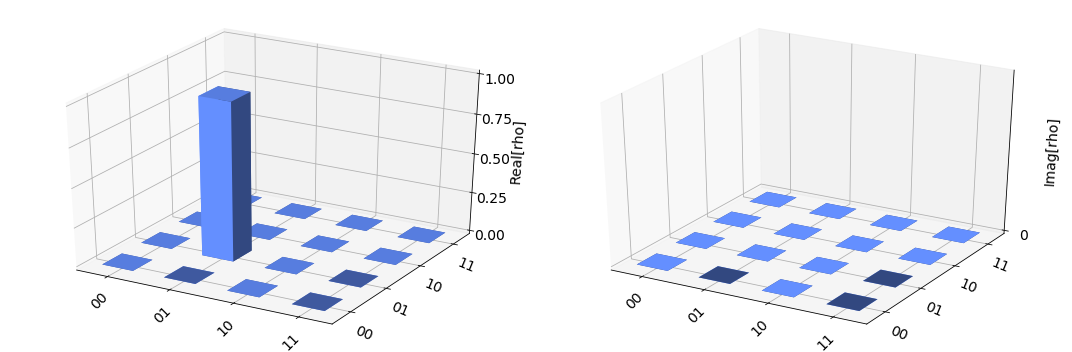

In [11]:
HF_state = HartreeFock(qubitOp.num_qubits, num_spin_orbitals, num_particles, map_type, 
                       qubit_reduction)
HF_state_vec = HF_state.construct_circuit(mode='vector')

# we can use qiskit's vizualisation module to plot the state
from qiskit.visualization import plot_state_city
plot_state_city(HF_state_vec)


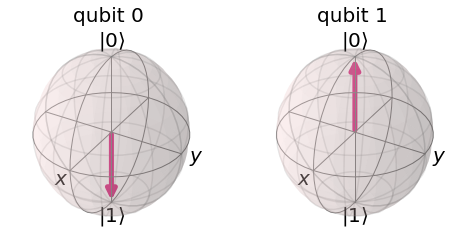

In [12]:
# you might want to visualise on the Bloch sphere for a non-superposition state
from qiskit.visualization import plot_state_city, plot_bloch_multivector
plot_bloch_multivector(HF_state_vec)

### Variational Forms
#### Hardware efficient heuristic Ansatz
Note that, as opposed to the classical case, in the case of a quantum chemistry Hamiltonian one has to sample over non-computational states that are superpositions, and therefore take advantage of using a quantum computer in the sampling part of the algorithm. Motivated by the quantum nature of the answer, we define a variational trial ansatz in this way: 

$$|\psi(\boldsymbol\theta)\rangle  = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a collection of cPhase gates (fully entangling gates), $U_\mathrm{single}(\boldsymbol\theta) = \prod_{i=1}^n Y(\theta_{i})Z(\theta_{n+i})$ are single-qubit $Y$ and $Z$ rotation, $n$ is the number of qubits and $m$ is the depth of the quantum circuit.

References and additional details:

[1] A. Kandala, A. Mezzacapo, K. Temme, M. Takita, M. Brink, J. M. Chow, and J. M. Gambetta, *Hardware-efficient Variational Quantum Eigensolver for Small Molecules and Quantum Magnets*, Nature 549, 242 (2017)

#### Unitary Coupled Cluster (UCC) Ansatz 

Another approach is to take inspiration from the classical UCC and electronic Hamiltonian and parameterise each excitation (single $\hat{T}_{1}(\vec{\theta})=\sum_{i ; m} \theta_{i}^{m} \hat{a}_{m}^{\dagger} \hat{a}_{i}$ and double $\hat{T}_{2}(\vec{\theta})=\frac{1}{2} \sum_{i, j ; m, n} \theta_{i, j}^{m, n} \hat{a}_{n}^{\dagger} \hat{a}_{m}^{\dagger} \hat{a}_{j} \hat{a}_{i}$) in operator $\hat T(\vec{\theta}) = \hat{T}_{1}(\vec{\theta}) + \hat{T}_{2}(\vec{\theta}) $ with an angle $\theta$. The unitary coupled cluster (UCC) wavefunction is given by:
$$|\psi(\boldsymbol\theta)\rangle= e^{\hat{T}(\theta)-\hat{T}^{\dagger}(\theta)}\left|\Phi_{0}\right\rangle$$
where the cluster operator is
$$ U(\boldsymbol\theta)=e^{\hat{T}(\theta)-\hat{T}^{\dagger}(\theta)} $$
the 
where $\left|\Phi_{0}\right\rangle$ is the HF state (e.g. $\left|1100\right\rangle$ for H2 in STO-3G basis)

In [13]:
var_form_uccsd = UCCSD(qubitOp.num_qubits, depth=1, 
                   num_orbitals=num_spin_orbitals, num_particles=num_particles, 
                   active_occupied=None, active_unoccupied=None, # you could modify the active space here 
                   initial_state=HF_state, qubit_mapping=map_type,
                   two_qubit_reduction=qubit_reduction, num_time_slices=1)

var_form_swaprz = SwapRZ(qubitOp.num_qubits, depth=1, 
                   initial_state=HF_state)

var_form_ryrz = RYRZ(qubitOp.num_qubits, depth=1, 
                   initial_state=HF_state)

# var_form_ry = RY(qubitOp.num_qubits, depth=1, 
#                    initial_state=HF_state)

2019-09-10 14:24:57,503:qiskit.chemistry.aqua_extensions.components.variational_forms.uccsd:INFO: We assume that the number of alphas and betas are the same.


### [Optional] Setup token to run the experiment on a real device
If you would like to run the experiment on a real device, you need to setup your account first.

Note: If you do not store your token yet, use `IBMQ.save_account('MY_API_TOKEN')` to store it first.
### Choose a simulator or real device
You can use the `qasm_simulator` or `ibmq_qasm_simulator` (cloud qasm simulator) to simulate faithfully the operations a real quantum computer would do. If you just want to simulate the processing of a quantum computer for now, you have to use `Aer`, which provides you with the `statevector_simulator`.

In [14]:
simultation_type = 'real_device'# qasm, qasm_cloud, real_device, state_vector

In [15]:
if simultation_type == 'qasm':
    
    sv_mode = False
    qasm_simulator = Aer.get_backend('qasm_simulator') # qasm_simulator, ibmq_qasm_simulator

    # uncomment this and put your token from the IBMQ website.
    #IBMQ.save_account('Your IBMQ API-token', overwrite=True)
    
    IBMQ.load_accounts() # connect with your token to IBMQ
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    print(provider.backends()) # lists available backends
    
    # set the noise model
    device = provider.get_backend('ibmq_16_melbourne') # ibmq_16_melbourne 
    properties = device.properties()
    coupling_map = device.configuration().coupling_map
    noise_model = noise.device.basic_device_noise_model(properties)
    basis_gates = noise_model.basis_gates
    shots = 8192 # choose the maximal number of shots (8192 is max on the ibmq_qasm_simulator)
    num_qubits = qubitOp.num_qubits
    
    # run on qasm_simulator 
    quantum_instance = QuantumInstance(qasm_simulator, shots=shots, basis_gates=basis_gates, coupling_map=coupling_map, noise_model=noise_model)

    # all the details of noise model
    print(noise_model.to_dict())
    
elif simultation_type == 'qasm_cloud':
    
    sv_mode = False
    # uncomment this and put your token from the IBMQ website.
    #IBMQ.save_account('Your IBMQ API-token', overwrite=True)
    IBMQ.load_accounts() # connect with your token to IBMQ
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    print(provider.backends()) # lists available backends
    
    qasm_simulator_cloud = provider.get_backend('ibmq_qasm_simulator') # ibmq_16_melbourne , ibmq_qasm_simulator
    
    # set the qasm cloud simulator 
    shots = 8192
    quantum_instance = QuantumInstance(qasm_simulator_cloud, shots=shots)

elif simultation_type == 'real_device':
    
    sv_mode = False
    # uncomment this and put your token from the IBMQ website.
    #IBMQ.save_account('Your IBMQ API-token', overwrite=True)
    
    IBMQ.load_accounts() # connect with your token to IBMQ
    provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    print(provider.backends()) # lists available backends
    
    # set the noise model
    device = provider.get_backend('ibmq_16_melbourne') # ibmq_16_melbourne 
    
    # run on qasm_simulator 
    shots = 8192
    quantum_instance = QuantumInstance(device, shots=shots)
    
elif simultation_type == 'state_vector':

    sv_mode = True
    num_qubits = qubitOp.num_qubits

    sv_simulator = Aer.get_backend('statevector_simulator')
    quantum_instance = QuantumInstance(sv_simulator) 
else:
    raise Exception('Please select for simultation_type == qasm, qasm_cloud, real_device, state_vector')


/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/providers/ibmq/utils/deprecation.py:53: DeprecationWarning: IBMQ.load_accounts() is being deprecated. Please use IBM Q Experience v2 credentials and IBMQ.load_account() (note the singular form) instead. You can find the instructions to make the updates here: 
https://github.com/Qiskit/qiskit-ibmq-provider#updating-to-the-new-ibm-q-experience
  DeprecationWarning)
/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:482: DeprecationWarning: Calling IBMQ.load_accounts() with v2 credentials. This is provided for backwards compatibility and may lead to unexpected behaviour when mixing v1 and v2 account credentials.
  'v1 and v2 account credentials.', DeprecationWarning)
2019-09-10 14:25:02,587:qiskit.aqua.quantum_instance:WARNING: The skip Qobj validation does not work for IBMQ provider. Disable it.
2019-09-10 14:25:02,588:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.9.0
Ba

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx4') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>]


If you want more details on the noise models and , refer to tutorial:

https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/aer/2_device_noise_simulation.ipynb

We prepared everything to setup the Variational Quantum Eigensolver at this point. We initialize 3 different VQE objects to show the circuits (`uccsd, ryrz, swaprz`) each one will use to evalute the energy.

In [16]:
vqe_uccsd = VQE(qubitOp, var_form_uccsd, optimizer)
vqe_ryrz = VQE(qubitOp, var_form_ryrz, optimizer)
vqe_swaprz = VQE(qubitOp, var_form_swaprz, optimizer)

2019-09-10 14:25:02,595:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <qiskit.chemistry.aqua_extensions.components.variational_forms.uccsd.UCCSD object at 0x1388adeb8>
-- optimizer: <qiskit.aqua.components.optimizers.l_bfgs_b.L_BFGS_B object at 0x13808ddd8>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x13889bb38>>
-- initial_point: [0. 0. 0.]
-- callback: None
-- operator: Representation: paulis, qubits: 2, size: 5
-- eval_count: 0
-- aux_operators: []
-- auto_conversion: True
Variational Form: UCCSD
-- num_parameters: 3
-- num_qubits: 2
-- bounds: [(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
-- z2_symmetries: Z2 symmetries:
Symmetries:
Single-Qubit Pauli X:
Cliffords:
Qubit index:
[]
Tapering values:
[]
-- depth: 1
-- num_orbit

To get a better understanding, what is happening on the quantum computer, we can have a look on the circuit that is executed. For each Pauli, we have a circuit that is used to evaluate its expectation value.

Circuit for: II
Circuit for: IZ
Circuit for: ZI
Circuit for: ZZ
Circuit for: XX


/anaconda3/envs/qiskit_camp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


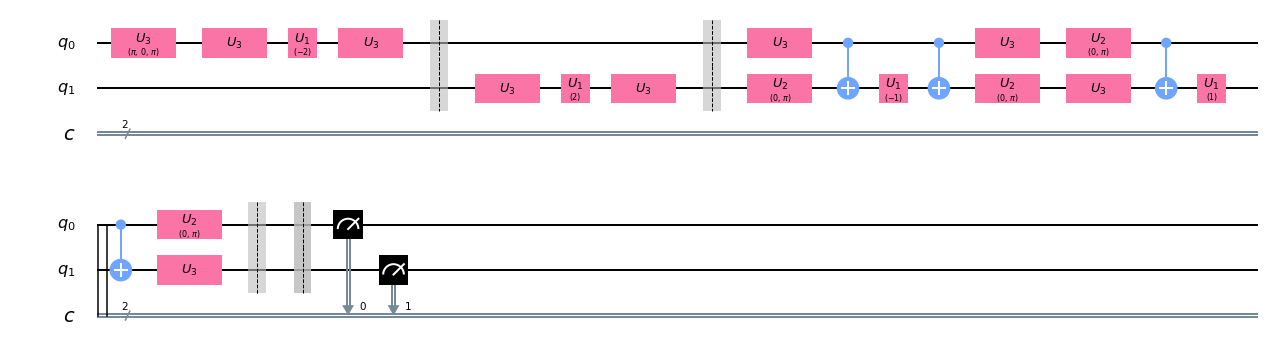

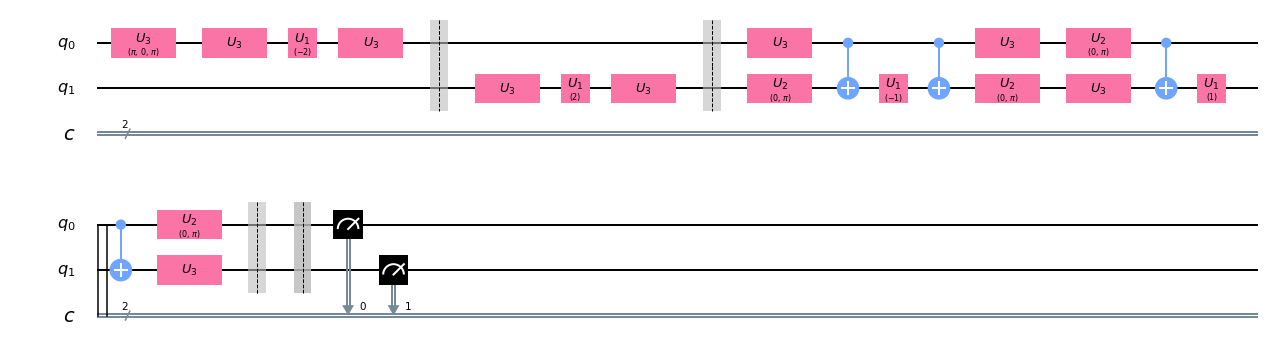

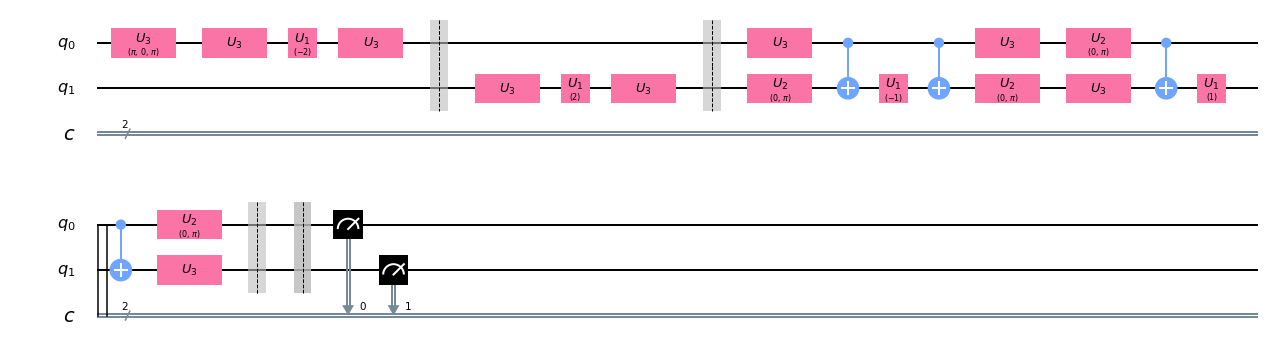

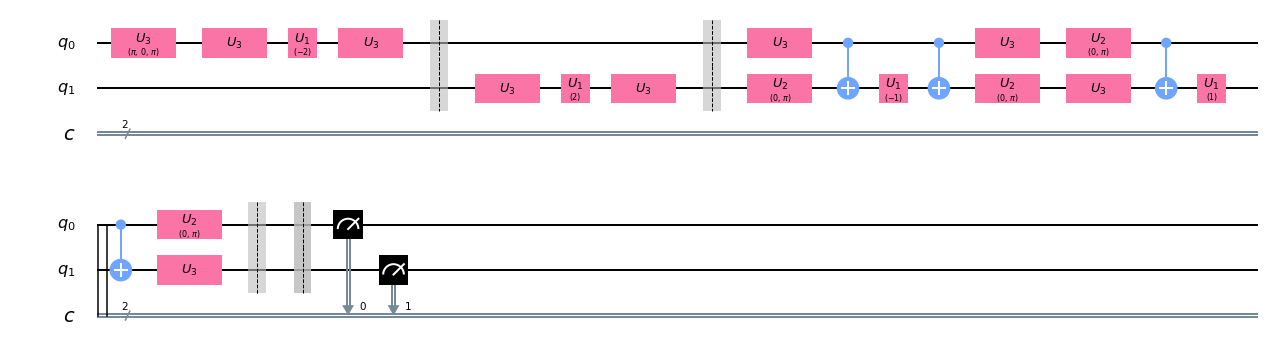

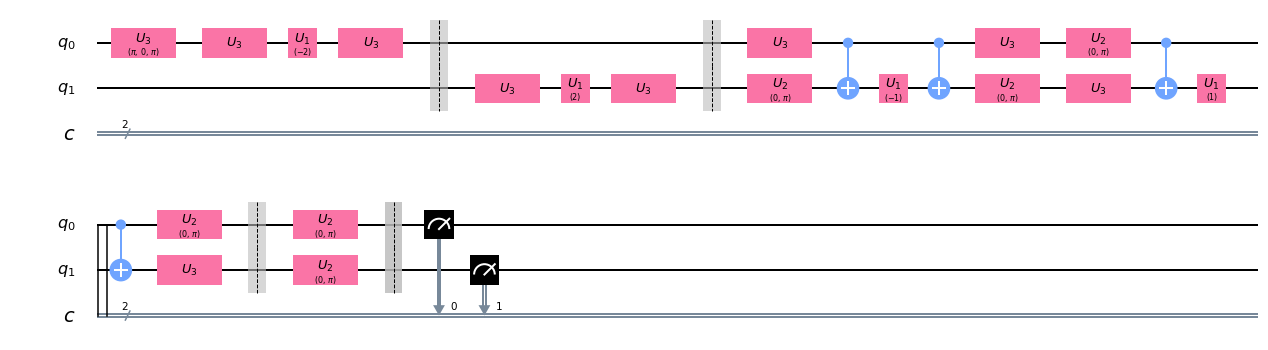

In [17]:
for pauli in qubitOp.paulis:
    print('Circuit for:', pauli[1])

circuit_uccsd = vqe_uccsd.construct_circuit(statevector_mode=sv_mode, parameter=np.ones(var_form_uccsd._num_parameters))
for i in range(len(circuit_uccsd)):
    fig = circuit_uccsd[i].draw(output='mpl')
    show_figure(fig)
    fig.show()

where all single-qubit operations are compiled down the **physical gates**:
$$U_3(\theta,\phi,\lambda) = \begin{pmatrix} \cos(\theta/2) & -e^{i\lambda}\sin(\theta/2) \\ e^{i\phi}\sin(\theta/2)  
& e^{i\lambda+i\phi}\cos(\theta/2) \end{pmatrix}$$ $$U_1(\lambda) = U_3(0,0,\lambda) = \begin{pmatrix} 1 & 0 \\ 0 & e^{i\lambda} \end{pmatrix}$$ $$U_2(\phi,\lambda) = U_3(\pi/2,\phi,\lambda) = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & -e^{i\lambda} \\ e^{i\phi} & e^{i\lambda+i\phi} \end{pmatrix}$$
for example the Hadamard gate is $U_2(0,\pi)$.

We read those graphs from left to right with $\left|q_0q_1\right\rangle$ notation convention. 
Our system requires 2 qubits $q_0$ and $q_1$ reduced from 4 due to two-qubit reduction from the parity mapping. 
The qubits always start to be in the initial state $|0\rangle$. 
Afterwards we act with unitary operations on the qubits. 

### Hardware-efficient Ansatz
#### particle-conserving Variational Form

We can also make a low-depth, particle conserving ansatz (like UCCSD), by using SWAP gates as entanglers to preserve the number of 1's (electrons) in the state.

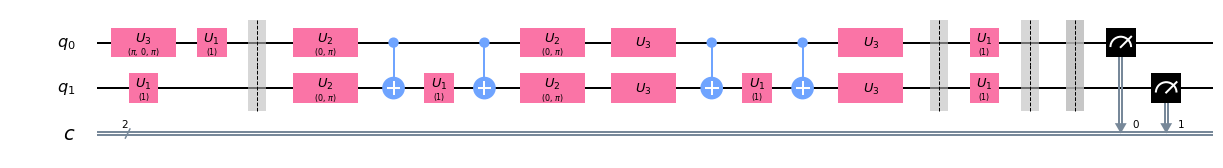

In [18]:
circuit_swaprz = vqe_swaprz.construct_circuit(statevector_mode=sv_mode, parameter=np.ones(var_form_swaprz._num_parameters))
circuit_swaprz[1].draw(output='mpl')

#### particle-non-conserving Variational Form

By using the CNOTs as entanglers we can get out of the $N_{el}$ Fock subspace and obtain a converged state which can be with different average particle number.

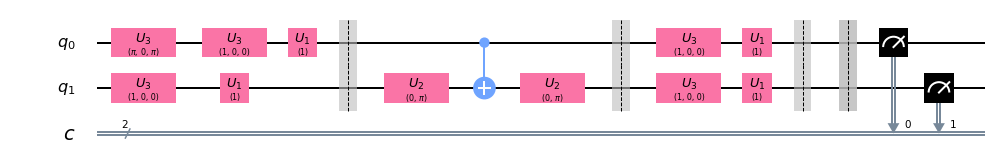

In [19]:
circuit_ryrz = vqe_ryrz.construct_circuit(statevector_mode=sv_mode, parameter=np.ones(var_form_ryrz._num_parameters))
circuit_ryrz[1].draw(output='mpl')

### Step 4: Run VQE algorithm and retrieve the results
The smallest eigenvalue is stored in the first entry of the `eigvals` key.

Note: Until now we have not done any calculation on the quantum computer. During the next step the algorithm is run on the real device or using the simulator.

In [ ]:
results = vqe_uccsd.run(quantum_instance)
print('The computed ground state energy is: {:.12f}'.format(results['eigvals'][0]))
print('The total ground state energy is: {:.12f}'.format(results['eigvals'][0] + nuclear_repulsion_energy))
print("Parameters: {}".format(results['opt_params']))

2019-09-10 14:32:19,958:qiskit.aqua.algorithms.adaptive.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[0. 0. 0.]
2019-09-10 14:33:20,278:qiskit.aqua.utils.run_circuits:WARNING: FAILURE: Can not get job id, Resubmit the qobj to get job id.Error:  
2019-09-10 14:34:20,297:qiskit.aqua.utils.run_circuits:WARNING: FAILURE: Can not get job id, Resubmit the qobj to get job id.Error:  
2019-09-10 14:35:20,311:qiskit.aqua.utils.run_circuits:WARNING: FAILURE: Can not get job id, Resubmit the qobj to get job id.Error:  
2019-09-10 14:36:20,326:qiskit.aqua.utils.run_circuits:WARNING: FAILURE: Can not get job id, Resubmit the qobj to get job id.Error:  
2019-09-10 14:37:20,342:qiskit.aqua.utils.run_circuits:WARNING: FAILURE: Can not get job id, Resubmit the qobj to get job id.Error:  
2019-09-10 14:38:20,360:qiskit.aqua.utils.run_circuits:WARNING: FAILURE: Can no

The Variational Quantum Eigensolver did arrive at the minimum. As it is a variatonal method we know that we are above the "exact" solution. This is indeed the property which is used, when running the VQE, because we know that every solution we find the one that has a lower energy is better than our previous one.

## Go a step further and evolve our system in time

Now we want to evolve our system in time, starting at an initial state. e.g. the Hartree Fock state, which we also used to start our optimization. 

In [ ]:
evolution_time = 100 # how many time steps
num_time_slices = 4 # number of Trotter steps
qr = QuantumRegister(num_qubits,'q')
initial_circuit = HF_state.construct_circuit(mode='circuit')

Now we time evolve our state with time-evolution operator by exponentiating the `qubitOp` $$e^{-i\hat{H}t} \underbrace{=}_{Trotter}\prod_{n} e^{-i\hat{H}t/n}$$ that is our electronic Hamiltonian and `num_time_slices`$=n$.

In [ ]:
evolution_circuit = qubitOp.evolve(state_in=initial_circuit, evo_time=evolution_time, evo_mode='circuit',num_time_slices=num_time_slices, expansion_mode='trotter')
evolution_circuit.draw(output='mpl')

We also want to run the circuit we just constructed. As a result we get the evolving state vector of the system for different evolution times `evo_time`.

#### Note: next cells about the time evolution of the state work only if you have selected the `simulation_type == state_vector` simulator.

In [ ]:
max_time=evolution_time
statevector_of_t = np.zeros([max_time,2*num_qubits])
for evo_t in range(max_time):
    evolution_circuit = qubitOp.evolve(state_in=initial_circuit, evo_time=evo_t, evo_mode='circuit',num_time_slices=num_time_slices, expansion_mode='trotter')
    result = quantum_instance.execute(evolution_circuit)
    statevector_of_t[evo_t,:] = np.asarray(result.get_statevector(evolution_circuit))

### Evolution of the state vector
Here we will plot the 4 fist entries of the state vector in red, blue, green and yellow.
Then we plot their absolute value.

In [ ]:
t = np.linspace(0,max_time-1,max_time)

plt.figure(1)
plt.plot(t,statevector_of_t[:,0],'-r', t,statevector_of_t[:,1],'-b', t,statevector_of_t[:,2],'-g', t,statevector_of_t[:,3],'-y')
plt.xlabel('time of evolution')
plt.ylabel('Re(Statevector[i])')
plt.show()

# absolute values of statevector entries
plt.figure(2)
plt.plot(t,np.abs(statevector_of_t[:,0]),'-r', t,np.abs(statevector_of_t[:,1]),'-b', t,np.abs(statevector_of_t[:,2]),'-g', t,np.abs(statevector_of_t[:,3]),'-y')
plt.xlabel('time of evolution')
plt.ylabel('|Statevector[i]|')
plt.show()

### Using Qiskit's visualize 
We can plot the state vector in the density matrix form $\rho =\sum _{j}p_{j}|\psi _{j}\rangle \langle \psi _{j}|$ and see the real and imaginary part of $p_j$ for off-diagonal elements.

In [ ]:
time_min = 0
time_max = 4
for i in range(time_min, time_max):
    fig = plot_state_city(statevector_of_t[i,:])
    show_figure(fig)
    fig.show()

##  H2 using declarative approach
We use this example to show you the declarative approach (provide an input file to qiskit) to solve chemistry problems. But the same is doable in a fully programmatic way (presented so far), especially for those users who are interested in learning the Qiskit Aqua and Qiskit Chemistry APIs as well as contributing new algorithmic components.

It takes the  HDF5 file located at *H2/H2_equilibrium_0.735_sto-3g.hdf5* and reads in the values of integrals. This allows not to recompute them every time and have exactly the same initial data.

In [ ]:
# First, we use classical eigendecomposition to get ground state energy (including nuclear repulsion energy) as reference.
qiskit_chemistry_dict = {
    'driver': {'name': 'HDF5'},
    'HDF5': {'hdf5_input': 'H2/H2_equilibrium_0.735_sto-3g.hdf5'},
    'operator': {'name':'hamiltonian', 
                 'qubit_mapping': 'parity', 
                 'two_qubit_reduction': True},
    'algorithm': {'name': 'ExactEigensolver'}
}
solver = QiskitChemistry()
result_classical = solver.run(qiskit_chemistry_dict)

# Second, we use variational quantum eigensolver (VQE)
qiskit_chemistry_dict['algorithm']['name'] = 'VQE'
qiskit_chemistry_dict['optimizer'] = {'name': 'SPSA', 'max_trials': 350}
qiskit_chemistry_dict['variational_form'] = {'name': 'RYRZ', 'depth': 3, 'entanglement':'full'}
backend = Aer.get_backend('statevector_simulator')
solver = QiskitChemistry()
result = solver.run(qiskit_chemistry_dict, backend=backend)

# We print out the results
print('Ground state energy (classical): {:.12f}'.format(result_classical['energy']))
print('Ground state energy (quantum)  : {:.12f}'.format(result['energy']))
print("====================================================")

# You can also print out other info in the field 'printable'
for line in result['printable']:
    print(line)

## Declarative approach : optimizing the potential energy surface 

The optimization considered previously is now performed for a molecule H$_2$ for different interatomic distances, and the corresponding nuclei Coulomb repulsion is added in order to obtain a potential energy surface. 


In [ ]:
molecule='H2'
maxiter = 10 # increase to allow optimizer to converge, set low to test
mol_distances = np.arange(0.2, 3.1, 0.2)
mol_distances_vqe = np.arange(0.2, 3.1,1)

# Exact eigensolver
qiskit_chemistry_dict_ee = {
    'driver': {'name': 'HDF5'},
    'HDF5': {'hdf5_input': ''},
    'operator': {'name':'hamiltonian', 
                 'qubit_mapping': 'parity', 
                 'two_qubit_reduction': True},
    'algorithm': {'name': 'ExactEigensolver'}
}

# choose which backend want to use
# backend = Aer.get_backend('qasm_simulator')
backend = Aer.get_backend('statevector_simulator')

# VQE
qiskit_chemistry_dict_vqe = {
    'driver': {'name': 'HDF5'},
    'HDF5': {'hdf5_input': ''},
    'operator': {'name':'hamiltonian', 
                 'qubit_mapping': 'parity', 
                 'two_qubit_reduction': True},
    'algorithm': {'name': 'VQE'},
    'optimizer': {'name': 'L_BFGS_B', 'maxiter': maxiter}, # or SPSA, max_trials=200
    'variational_form': {'name': 'RY', 'depth': 1, 'entanglement':'full'}, # RYRZ, UCCSD (delete entanglement field)
    'backend': {'shots': 1024}
}

algos = ['ExactEigensolver', 'VQE']
energy = np.zeros((len(algos), len(mol_distances)))
energy_vqe = np.zeros((len(algos), len(mol_distances_vqe)))

# Run the algos
for j, algo in enumerate([qiskit_chemistry_dict_ee, qiskit_chemistry_dict_vqe]):
    algo_name = algo['algorithm']['name']
    print("Using {}".format(algo_name))
    if algo_name == 'VQE':
        for i, dis in enumerate(mol_distances_vqe):
            print("Processing atomic distance: {:1.1f} Angstrom".format(dis), end='\r')
            algo['HDF5']['hdf5_input'] = "{}/{:1.1f}_sto-3g.hdf5".format(molecule, dis)
            result = solver.run(algo, backend=backend if algo_name == 'VQE' else None)
            energy_vqe[j][i] = result['energy']
    else:
        for i, dis in enumerate(mol_distances):
            print("Processing atomic distance: {:1.1f} Angstrom".format(dis), end='\r')
            algo['HDF5']['hdf5_input'] = "{}/{:1.1f}_sto-3g.hdf5".format(molecule, dis)
            result = solver.run(algo, backend=backend if algo_name == 'VQE' else None)
            energy[j][i] = result['energy']
        

Now we plot the results of the dissociation profile for the executed algorithms

In [ ]:
for i, algo in enumerate(algos):
    if algo == 'VQE':
        plt.plot(mol_distances_vqe, energy_vqe[i], label=algo, linestyle='', marker='x')
    else:
        plt.plot(mol_distances, energy[i], label=algo)
        
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy [Ha]')
plt.legend()
plt.show()

We want now to visualise the error we are making with the exact solution. 

In [ ]:
mol_distances_errors = []
energy_errors = []

for i, pts_vqe in enumerate(mol_distances_vqe):
    for j, pts in enumerate(mol_distances):
        # find the entries with same bond distances
        if pts_vqe == pts:
            mol_distances_errors.append(pts)
            energy_errors.append(abs(energy[0][j]-energy_vqe[1][i]))
            
# plot the errors
print('Errors |Exact - VQE|:\n',energy_errors)
plt.plot(mol_distances_errors, energy_errors, label='Errors(Exact-VQE)', linestyle='', marker='x')

# chemical accuracy of 1 mHa
plt.hlines(0.001, 0, 3, colors='k', label='Chemical Accuracy')
plt.legend()
plt.show()

# Exercises

- Set the VQE for H2 using UCCSD, RYRZ, SWAPRZ in STO-3G and compare the results for a given geometry using state_vector simulator with L_BFGS_B optimizer. What is the error with respect to UCCSD ?
- Change depth parameter (repetition of circuit with independent parameters) of RYRZ, SWAPRZ circuit to reach chemical accuracy. What depth do you need ?
- [Hard] Change just the basis set from STO-3G to 6-31G for H2 molecule and play with active_occupied/unoccupied orbital parameters (change of active space) in UCCSD Variational Form. This is basically the work we've done in [2] so you will be performing some cutting edge research ! :-)

[2] Panagiotis Kl. Barkoutsos, Jerome F. Gonthier, Igor Sokolov, Nikolaj Moll, Gian Salis, Andreas Fuhrer, Marc Ganzhorn, Daniel J. Egger, Matthias Troyer, Antonio Mezzacapo, Stefan Filipp, and Ivano Tavernelli *Quantum algorithms for electronic structure calculations: Particle-hole Hamiltonian and optimized wave-function expansions* Phys. Rev. A 98, 022322 – Published 20 August 2018


In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright